# Data Augmentation
We apply data augmentation and see the impact of it on the results of simple models.

Use the kernel "cloned_CNN2" to use pytorchvision.

In [1]:
from buildDataset import *
%matplotlib inline
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
root_path =      DATAPATHS["preprocessed"]
from sklearn.model_selection import KFold

from sklearn.metrics import PrecisionRecallDisplay

c:\Users\line\Desktop\Mauro\2_Preprocessing_Code\amd\prl\dataset.py:8: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology import selem


In [2]:
# for data augmentation
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [3]:
def score_model_PR(model, X, y, params = None, cv=None, seq_X = None, seq_y = None, N_iter = 3, plotMatrix = None, plotROC = None, setTreshold = None, ax2 = None, modelname = '', label = None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    Input:
    - X OCT scans, np.array of shape (193536, 70)
    - y label, np.array of shape (193536,) 
    - N_iter: number of iterations augmentated data is added
    - seq_X: iaa.Sequential, applied on X. 
    - seq_y: iaa.Sequential, applied on y. Should correspond to seq_X.
    """
    #smoter = SMOTE(random_state=42)
    
    scores = []
    y_real = []
    y_proba = []
    
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for fold, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
        # Get the training data
        X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
        # Get the validation data
        X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

        # Data augmentation: need to reshape to apply transformation per images.
        X_train_fold = X_train_fold.reshape((-1, 768, 70, 1))
        y_train_fold = y_train_fold.reshape((-1, 768, 1))
        X_train_aug = X_train_fold.copy()
        y_train_aug = y_train_fold.copy()

        if seq_X and seq_y:
            # add augmented data N_iter number of times.
            for _ in range(N_iter):
                X_aug_new = seq_X(images = X_train_fold)
                X_train_aug = np.append(X_train_aug, X_aug_new, axis = 0)

                segmap = np.zeros(X_aug_new.shape[:3], dtype = np.uint8)
                segmap[:,:,:] = y_train_fold
                segmap = SegmentationMapsOnImage(segmap, shape = X_train_fold.shape[:3])
                y_aug_new = seq_y(images = segmap.get_arr().astype(np.uint8))[:, :, 0].reshape((-1, 768, 1))
                y_train_aug = np.append(y_train_aug, y_aug_new, axis = 0)
                

        # Upsample only the data in the training section

        X_train_aug = X_train_aug.reshape((-1, 70))
        y_train_aug = y_train_aug.reshape((-1,))
        X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_aug,y_train_aug)

        # Fit the model on the upsampled training data
        if params:
            model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
        else:
            model_obj = model().fit(X_train_fold_upsample, y_train_fold_upsample)
        pred_proba = model_obj.predict_proba(X_val_fold)
        y_real.append(y_val_fold)
        preds = pred_proba[:,1]
        y_proba.append(preds)
        if(plotMatrix):
            # Display confusion matrix
            ConfusionMatrixDisplay.from_estimator(model_obj, X_val_fold, y_val_fold)
            plt.show()
        if(plotROC):
            viz = PrecisionRecallDisplay.from_predictions(
                y_val_fold,
                preds,
                name=f"PR fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
            )

        if(setTreshold != None):
            predictions = (model_obj.predict_proba(X_val_fold)[:,1] >= setTreshold).astype(bool)
        # Score the model on the (non-upsampled) validation data
        else:
            predictions = model_obj.predict(X_val_fold)
        scores.append(recall_score(y_val_fold, predictions))
        scores.append(precision_score(y_val_fold, predictions))
        scores.append(accuracy_score(y_val_fold, predictions))
        scores.append(f1_score(y_val_fold, predictions))
    
    if seq_X:
        print("N_iter: ", N_iter)
        print("X train fold shape: ", X_train_fold.shape)
        print("X train aug shape: ", X_train_aug.shape) 

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    if(plotROC):
        PrecisionRecallDisplay.from_predictions(
                    y_real,
                    y_proba,
                    name=f"PR AVG",
                    color="b",
                    lw=2,
                    alpha=0.8,
                    ax=ax,
                )
    if ax2:
        if label != None:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{label}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )
        else:
            PrecisionRecallDisplay.from_predictions(
                y_real,
                y_proba,
                name=f"{str(list(params.items()))} {modelname}",
                lw=2,
                alpha=0.8,
                ax=ax2,
            )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="Precision",
        ylabel="Recall",
        title=f"Mean PR curve",
    )

    plt.show()

    return np.array(scores)

In [4]:
X,y = getBalancedXYData(mode = 'raw',normmode = 'EQ-hist')
print(X.shape)
print(y.shape)
print(768*14*18)

(193536, 70)
(193536,)
193536


We add gaussian noise in the sequence of transformations. To use that function, we need to change the dtype of X from float64 to float32, otherwise it is not supported.

In [5]:
X_float32 = X.astype('float32')
X_min = np.min(X_float32)
X_max = np.max(X_float32)
print("min of X: ", X_min)
print("max of X: ", X_max)

min of X:  0.0045237327
max of X:  1.0


By adding vertical flip, we need to be careful because the labels also changes.

In [6]:
# Sequence of transformations that will be applied on the images
seq_X = iaa.Sequential([
    iaa.Flipud(0.5, random_state=1), # vertical flips (since the images are vertical)
    # iaa.Crop(percent=(0, 0.1)), # random crops

    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 1.5))
    ),

    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),

    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.08))

], random_order=True) # apply augmenters in random order

# Corresponding sequence of transformations that will be applied on the labels
seq_y = iaa.Sequential([
    iaa.Flipud(0.5, random_state=1) # vertical flips (since the images are vertical)
], random_order=True) 

## Example of augmentation on the data, with visualizations

Notice that the labels are also flipped when the image is flipped.

to apply transformations, the images should be 4D numpy array of shape (N, height, width, channels) or a list of 3D numpy arrays, having shapes (height, width, channels).

In [7]:
X_images = X.reshape((14*18, 768, 70, 1)).astype('float32') #type float32 to be supported by the functions from iaa.
X_images.shape

(252, 768, 70, 1)

Without any augmentation


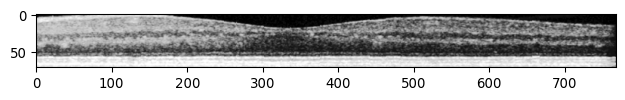

Gaussian Blur


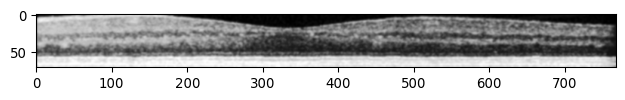

Linear contrast


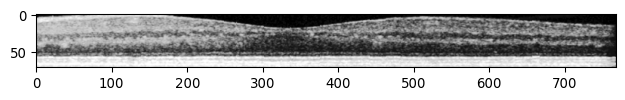

Gaussian noise


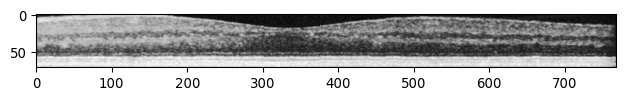

In [9]:
print("Without any augmentation")
ia.imshow(X_images[0,:,:,0].T)
                     
aug = iaa.GaussianBlur(sigma=(0, 1.5))
print("Gaussian Blur")
ia.imshow(aug.augment_image(X_images[0])[:,:,0].T)

aug = iaa.LinearContrast((0.75, 1.5))
print("Linear contrast")
ia.imshow(aug.augment_image(X_images[0])[:,:,0].T)

aug = iaa.AdditiveGaussianNoise(scale=(0.0, 0.08))
print("Gaussian noise")
ia.imshow(aug.augment_image(X_images[0])[:,:,0].T)


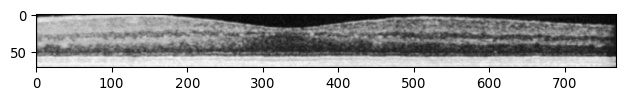

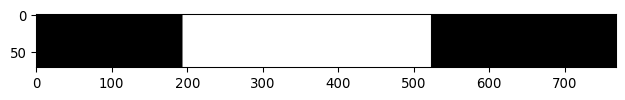

In [10]:
# apply augmentation on X
X_float32_aug = seq_X(images = X_images)
ia.imshow(X_float32_aug[0,:,:,0].T)

# first change the format of y
y_images = y.reshape((14*18, 768,1))
segmap = np.zeros(X_images.shape[:3], dtype = np.int32)
segmap[:,:,:] = y_images
segmap = SegmentationMapsOnImage(segmap, shape = X_images.shape[:3])

# apply augmentation on y
y_aug = seq_y(images = segmap.get_arr().astype(np.uint8))
ia.imshow(y_aug[0].T)

In [25]:
def imshow_labels(X, y):
    """plot labels y (blue) over image X (red). 
    Input:
    - X array of shape (768, 70)
    - y array of shape (768)
    """
    image_rgb = np.zeros((768, 70, 3))
    image_rgb[:, :, 0] = X*0.7
    image_rgb[:, :, 1] = X*0.6 + y*0.1
    image_rgb[:, :, 2] = y*0.7
    ia.imshow(image_rgb.transpose((1, 0, 2)))

Image number  0


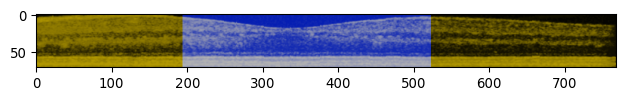

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


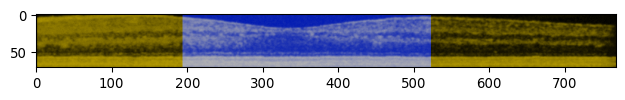

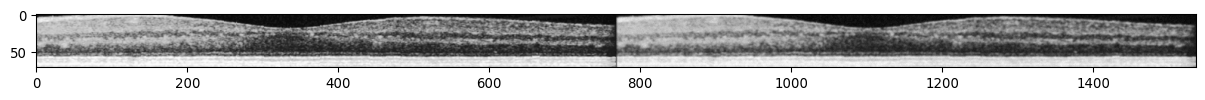

Image number  1


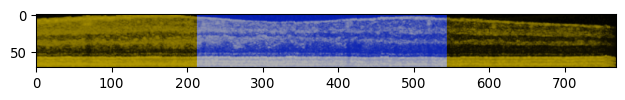

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


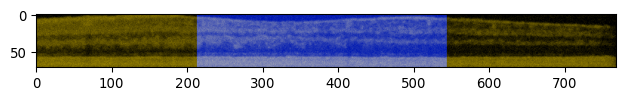

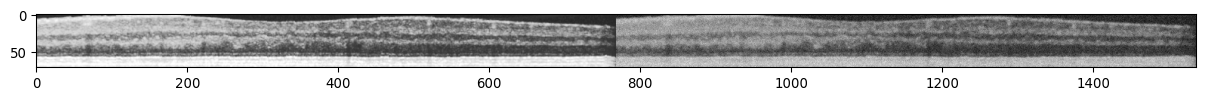

Image number  2


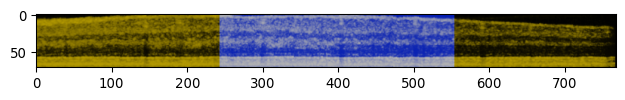

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


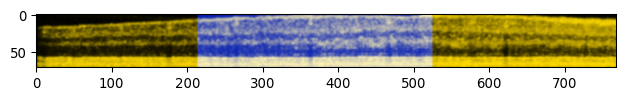

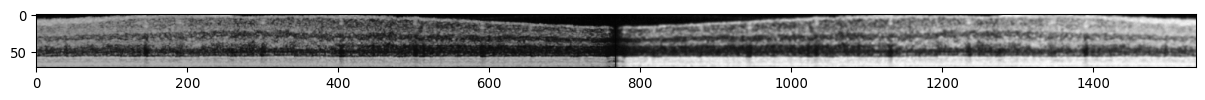

Image number  3


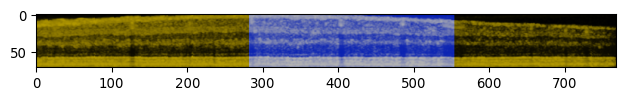

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


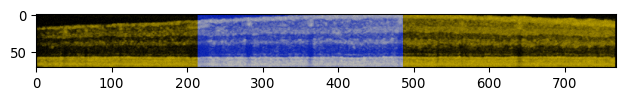

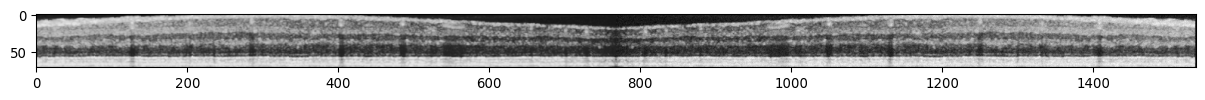

Image number  4


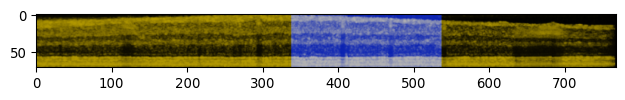

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


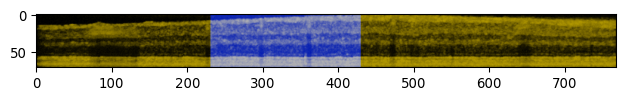

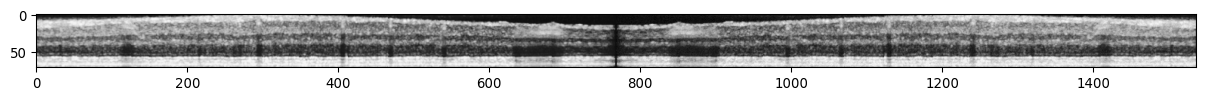

In [27]:
for j in range(5):
    print("Image number ", j)
    # not augmented image
    imshow_labels(X_images[j,:,:,0], y_images[j, :])

    # augmented image
    imshow_labels(X_float32_aug[j,:,:,0], y_aug[j, :])
    
    ia.imshow(np.hstack([X_images[j,:,:,0].T, X_float32_aug[j,:,:,0].T]))

## Model (Gaussian NB) with data augmentation

N_iter:  3
X train fold shape:  (210, 768, 70, 1)
X train aug shape:  (645120, 70)


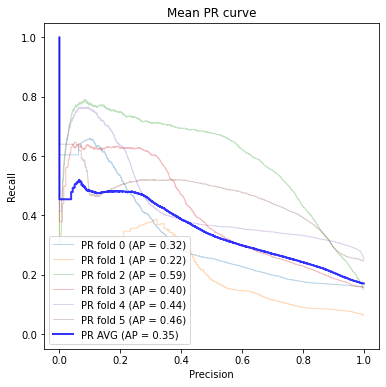

Here are the recall scores: [1. 1. 1. 1. 1. 1.]
Here are the precisions scores: [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
Here are the accuracies scores: [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
Here are the f1 scores: [0.27369548 0.11671289 0.26047565 0.27156789 0.39558308 0.39566288]


In [28]:
kf = KFold(n_splits=6, shuffle=False)

model = GaussianNB
scores = score_model_PR(model, X_float32, y, params = None, cv=kf, seq_X = seq_X, seq_y = seq_y, plotMatrix = False, plotROC = True, setTreshold = False)
print(f'Here are the recall scores: {scores[::4]}')
print(f'Here are the precisions scores: {scores[1::4]}')
print(f'Here are the accuracies scores: {scores[2::4]}')
print(f'Here are the f1 scores: {scores[3::4]}')

### Next: iterate to see how many data augmentations give the best results, and compare it to the PR curve without data augmentation.

In [46]:
import warnings
from matplotlib.cm import get_cmap
from sklearn.utils import shuffle

name = 'Dark2'
cmap = get_cmap(name)
colors =cmap.colors


def compare_models_PR(models, X, y, params = None, cv=None, seq_X = None, seq_y = None, N_iters = [0, 1], plotMatrix = None, plotROC = None, ax_avg = None, setTreshold = None, ax2 = None, modelname = '', label = None):
    """
    Creates folds manually, and upsamples within each fold.
    Returns an array of validation (recall) scores
    Plot the models PR on a single plot, in order to compare them. 
    Each model has its corresponding N_iter.
    Input:
    - models: list of model
    - X OCT scans, np.array of shape (193536, 70)
    - y label, np.array of shape (193536,) 
    - N_iters: list of number of iterations augmentated data is added
    - seq_X: iaa.Sequential, applied on X. 
    - seq_y: iaa.Sequential, applied on y. Should correspond to seq_X.
    """
    #smoter = SMOTE(random_state=42)
    if type(models) != list or type(N_iters) != list:
        warnings.warn('models and N_iters should be lists.')
    if len(models) != len(N_iters):
        warnings.warn('Lists models and N_iters should have the same length.')
    
    scores_models = np.zeros((len(models), 4*cv.get_n_splits(X, y)))

    for cnt_model, model in enumerate(models):
        N_iter = N_iters[cnt_model]
        scores = []
        y_real = []
        y_proba = []
        
        mean_fpr = np.linspace(0, 1, 100)
        if ax_avg:
            ax = ax_avg
        else:
            fig, ax = plt.subplots(figsize=(6, 6))
        
        for fold, (train_fold_index, val_fold_index) in enumerate(cv.split(X, y)):
            # Get the training data
            X_train_fold, y_train_fold = X[train_fold_index], y[train_fold_index]
            # Get the validation data
            X_val_fold, y_val_fold = X[val_fold_index], y[val_fold_index]

            # Data augmentation: need to reshape to apply transformation per images.
            X_train_fold = X_train_fold.reshape((-1, 768, 70, 1))
            y_train_fold = y_train_fold.reshape((-1, 768, 1))
            X_train_aug = X_train_fold.copy()
            y_train_aug = y_train_fold.copy()

            if seq_X and seq_y:
                # add augmented data N_iter number of times.
                for _ in range(N_iter):
                    X_aug_new = seq_X(images = X_train_fold)
                    X_train_aug = np.append(X_train_aug, X_aug_new, axis = 0)

                    segmap = np.zeros(X_aug_new.shape[:3], dtype = np.uint8)
                    segmap[:,:,:] = y_train_fold
                    segmap = SegmentationMapsOnImage(segmap, shape = X_train_fold.shape[:3])
                    y_aug_new = seq_y(images = segmap.get_arr().astype(np.uint8))[:, :, 0].reshape((-1, 768, 1))
                    y_train_aug = np.append(y_train_aug, y_aug_new, axis = 0)
                    

            # Upsample only the data in the training section

            X_train_aug = X_train_aug.reshape((-1, 70))
            y_train_aug = y_train_aug.reshape((-1,))
            X_train_fold_upsample, y_train_fold_upsample = upsample(X_train_aug,y_train_aug)

            # Fit the model on the upsampled training data
            if params:
                model_obj = model(**params).fit(X_train_fold_upsample, y_train_fold_upsample)
            else:
                model_obj = model().fit(X_train_fold_upsample, y_train_fold_upsample)
            pred_proba = model_obj.predict_proba(X_val_fold)
            y_real.append(y_val_fold)
            preds = pred_proba[:,1]
            y_proba.append(preds)
            if(plotMatrix):
                # Display confusion matrix
                ConfusionMatrixDisplay.from_estimator(model_obj, X_val_fold, y_val_fold)
                plt.show()
            if(plotROC):
                viz = PrecisionRecallDisplay.from_predictions(
                    y_val_fold,
                    preds,
                    name=f"PR fold {fold}",
                    alpha=0.3,
                    lw=1,
                    ax=ax,
                    color= colors[cnt_model],
                )

            if(setTreshold != None):
                predictions = (model_obj.predict_proba(X_val_fold)[:,1] >= setTreshold).astype(bool)
            # Score the model on the (non-upsampled) validation data
            else:
                predictions = model_obj.predict(X_val_fold)
            scores.append(recall_score(y_val_fold, predictions))
            scores.append(precision_score(y_val_fold, predictions))
            scores.append(accuracy_score(y_val_fold, predictions))
            scores.append(f1_score(y_val_fold, predictions))
        
        scores_models[cnt_model] = np.array(scores)

        if seq_X:
            print("N_iter: ", N_iter)
            print("Total number of images: ", X_train_fold.shape[0]*(N_iter+1))

        y_real = np.concatenate(y_real)
        y_proba = np.concatenate(y_proba)
        if(plotROC):
            PrecisionRecallDisplay.from_predictions(
                        y_real,
                        y_proba,
                        name=f"PR AVG, tot. images={X_train_fold.shape[0]*(N_iter+1)}",
                        color=colors[cnt_model],
                        lw=2,
                        alpha=1,
                        ax=ax,
                    )
        if ax2:
            if label != None:
                PrecisionRecallDisplay.from_predictions(
                    y_real,
                    y_proba,
                    name=f"{label}",
                    lw=2,
                    alpha=0.8,
                    ax=ax2,
                )
            else:
                PrecisionRecallDisplay.from_predictions(
                    y_real,
                    y_proba,
                    name=f"{str(list(params.items()))} {modelname}",
                    lw=2,
                    alpha=0.8,
                    ax=ax2,
                )

        ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            xlabel="Precision",
            ylabel="Recall",
            title=f"Mean PR curve",
        )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

    return scores_models

N_iter:  0
Total number of images:  210
N_iter:  1
Total number of images:  420
N_iter:  2
Total number of images:  630
N_iter:  4
Total number of images:  1050
N_iter:  8
Total number of images:  1890


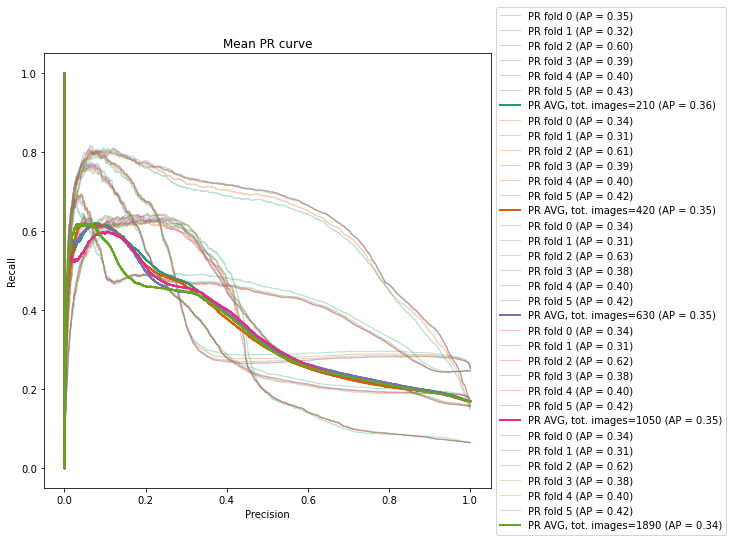

Here are the recall scores:
 [[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
Here are the precisions scores:
 [[0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]]
Here are the accuracies scores:
 [[0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]
 [0.15854415 0.06197297 0.14973958 0.15711806 0.24655878 0.24662078]]
Here are the f1 scores:
 [[0.27369548 0.11671289 0.26047565 0.27156789 0.39558308 0.39566288]
 [0.27369548 

In [48]:
N_iters =  [0, 1, 2, 4, 8]
fig, ax = plt.subplots(figsize=(8, 8))
models = [GaussianNB for _ in N_iters]
kf = KFold(n_splits=6, shuffle=False)
smooth = 100 # from Mauro's report.
params = {
            'var_smoothing': smooth,
        }

scores = compare_models_PR(models, X_float32, y, params = params, cv=kf, seq_X = seq_X, seq_y = seq_y, N_iters = N_iters, plotMatrix = False, plotROC = True, ax_avg = ax, setTreshold = False)
print(f'Here are the recall scores:\n {scores[:, ::4]}')
print(f'Here are the precisions scores:\n {scores[:, 1::4]}')
print(f'Here are the accuracies scores:\n {scores[:, 2::4]}')
print(f'Here are the f1 scores:\n {scores[:, 3::4]}')

## Random forest classifier with data augmentation

KeyboardInterrupt: 

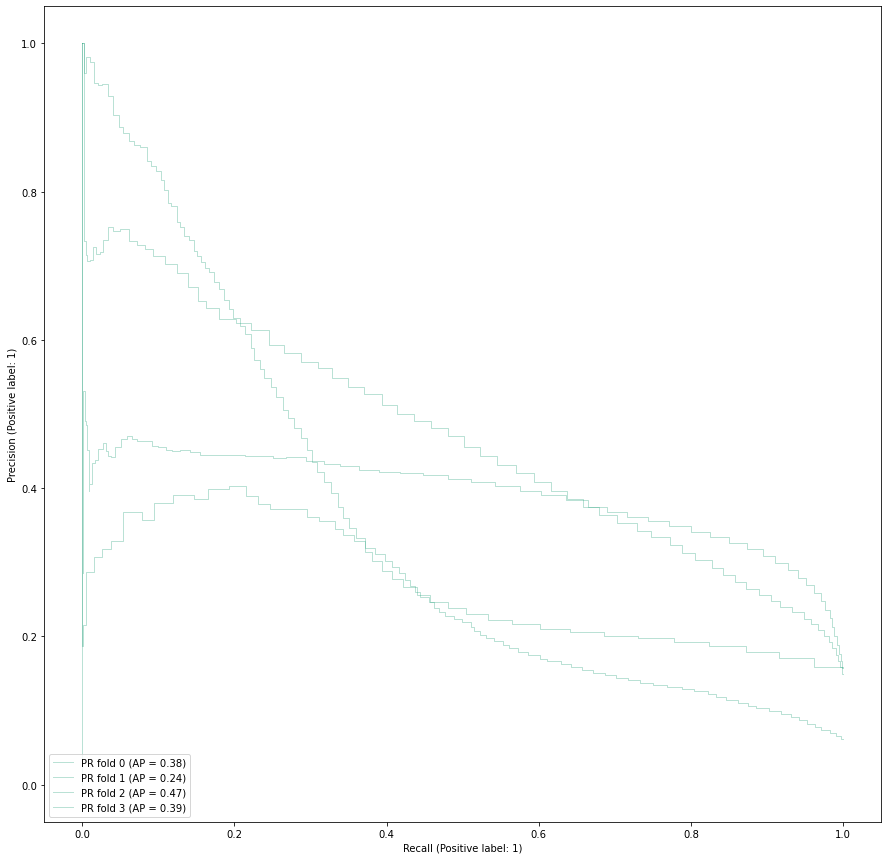

In [12]:
N_iters =  [0, 1, 2, 4, 8]
fig, ax = plt.subplots(figsize=(15, 15))
models = [RandomForestClassifier for _ in N_iters]
kf = KFold(n_splits=6, shuffle=False)
num = 75 # from Mauro's report, was the best parameter.
params = {
            'n_estimators': num,
        }

scores = compare_models_PR(models, X_float32, y, params = params, cv=kf, seq_X = seq_X, seq_y = seq_y, N_iters = N_iters, plotMatrix = False, plotROC = True, ax_avg = ax, setTreshold = False)
print(f'Here are the recall scores:\n {scores[:, ::4]}')
print(f'Here are the precisions scores:\n {scores[:, 1::4]}')
print(f'Here are the accuracies scores:\n {scores[:, 2::4]}')
print(f'Here are the f1 scores:\n {scores[:, 3::4]}')